In [378]:
ls

CONTRIBUTING.md*                 database.sqlite*
Final notebook.ipynb             index.ipynb*
LICENSE.md*                      mod2_project-db_TRANSFORM.ipynb
README.md*                       weather.csv
charts/


In [220]:
import pandas as pd
import sqlite3 
import requests
import time
import datetime
import matplotlib.pyplot as plt

In [ ]:
import pymongo


I'm going to run a series of queries that pull out the individual stats for each team. I find it easier to build a new dataframe from scratch than manipulating dataframes together

First step is a list of teams:

In [158]:
list_of_teams = [x[0] for x in c.execute('''select TeamName from Unique_Teams where TeamName in
(select HomeTeam from matches where season is 2011)''').fetchall()]
list_of_teams

['Bayern Munich',
 'Dortmund',
 'Leverkusen',
 'Schalke 04',
 "M'gladbach",
 'Wolfsburg',
 'FC Koln',
 'Hoffenheim',
 'Hertha',
 'Mainz',
 'Hamburg',
 'Werder Bremen',
 'Ein Frankfurt',
 'Augsburg',
 'Freiburg',
 'Stuttgart',
 'Hannover',
 'Ingolstadt',
 'Paderborn',
 'Nurnberg',
 'Braunschweig',
 'Greuther Furth',
 'Fortuna Dusseldorf',
 'Kaiserslautern',
 'St Pauli',
 'Bochum',
 'Karlsruhe',
 'Cottbus',
 'Duisburg',
 'Hansa Rostock',
 'Aachen',
 'Union Berlin',
 'Dresden',
 'Erzgebirge Aue',
 'Munich 1860',
 'Frankfurt FSV',
 'Arsenal',
 'Aston Villa',
 'Chelsea',
 'Liverpool',
 'Man City',
 'Newcastle',
 'Norwich',
 'Tottenham',
 'Everton',
 'Blackburn',
 'Man United',
 'QPR',
 'Bolton',
 'Sunderland',
 'Fulham',
 'West Brom',
 'Wolves',
 'Wigan',
 'Stoke',
 'Swansea']

Next a series of functions that find each of the particular stats. The number of games, the number of goals, and wins and losses are pretty simple pulls

In [167]:
def num_games(team_name):
    conn = sqlite3.connect('database.sqlite')
    c = conn.cursor()
    df = pd.DataFrame(c.execute("""select * from matches 
    where season is 2011 
    and (HomeTeam is "{}" or AwayTeam is "{}") """.format(team_name,team_name)).fetchall())
    df.columns = [x[0] for x in c.description]
    return len(df)

In [170]:
def num_goals(team_name):
    H = c.execute("""select sum(FTHG) from matches 
    where season is 2011 
    and HomeTeam is "{}" 
     """.format(team_name)).fetchall()[0][0]
    
    A = c.execute("""select sum(FTAG) from matches 
    where season is 2011 
    and AwayTeam is "{}" """.format(team_name)).fetchall()[0][0]
    return H+A

In [171]:
def num_wins(team_name):
    conn = sqlite3.connect('database.sqlite')
    c = conn.cursor()
    H = c.execute("""select count(FTR) from matches 
    where season is 2011 
    and HomeTeam is "{}" 
    and FTR is 'H' """.format(team_name)).fetchall()[0][0]
    
    A = c.execute("""select count(FTR) from matches 
    where season is 2011 
    and AwayTeam is "{}" 
    and FTR is 'A' """.format(team_name)).fetchall()[0][0]
    return H+A

In [174]:
def num_loss(team_name):
    conn = sqlite3.connect('database.sqlite')
    c = conn.cursor()
    H = c.execute("""select count(FTR) from matches 
    where season is 2011 
    and HomeTeam is "{}" 
    and FTR is 'A' """.format(team_name)).fetchall()[0][0]
    
    A = c.execute("""select count(FTR) from matches 
    where season is 2011 
    and AwayTeam is "{}" 
    and FTR is 'H' """.format(team_name)).fetchall()[0][0]
    return H+A

In [195]:
def num_draw(team_name):
    conn = sqlite3.connect('database.sqlite')
    c = conn.cursor()
    D = c.execute("""select count(FTR) from matches 
    where season is 2011 
    and (HomeTeam is "{}" or AwayTeam is "{}")
    and FTR is 'D' """.format(team_name,team_name)).fetchall()[0][0]
    return D

The hardest part here is pulling out the weather data. There are too many individual matches to make it practical to loop over them from both home and away sides. Instead, I decided to find the weather for each date (or rather, to find out if it was raining or not) and then store that in its own dataframe I can check against later.

The easiest way to think about it was to cycle through days, so first you need a function to deliver a properly formatted date. I used the datetime module. I also have a function that creates a properly formatted url given a particular day. Then I could just loop through 365 dates starting in 2011 and create my weather table.

In [114]:
def url_maker(day):
    start = datetime.datetime(2011,6,1)
    result = start+datetime.timedelta(day)
    year = str(result.year)
    month = str(result.month) if len(str(result.month))==2 else '0'+str(result.month)
    day = str(result.day) if len(str(result.day)) == 2 else '0'+str(result.day)
    part1 = 'https://api.darksky.net/forecast/1281fd7df229b9bd1c337bf4a3b75616/'
    location = '52.5200,13.4050,'
    date = year+'-'+month+'-'+day
    final = 'T12:00:00?exclude=[currently,minutely,hourly]'
    return part1+location+date+final

def date_maker(day):
    start = datetime.datetime(2011,6,1)
    result = start+datetime.timedelta(day)
    year = str(result.year)
    month = str(result.month) if len(str(result.month))==2 else '0'+str(result.month)
    day = str(result.day) if len(str(result.day)) == 2 else '0'+str(result.day)
    return year+'-'+month+'-'+day

In [121]:
weather = []
for n in range(0,365):
    url = url_maker(n)
    resp = requests.get(url)
    
    if resp.json()['daily']['data'][0]['precipProbability']:
        precip = resp.json()['daily']['data'][0]['precipType']
    else:
        precip = 'NA'
    weather.append([date_maker(n),{'precip_type':precip}])
weather_df = pd.DataFrame([x[1] for x in weather], index=[x[0] for x in weather])
weather_df.head()


,precip_type
2011-06-01,rain
2011-06-02,NA
2011-06-03,NA
2011-06-04,NA
2011-06-05,NA


And let's save down the weather data so that I don't need to query the API again:

In [243]:
weather_df.to_csv('weather.csv')

In [376]:
weather_df = pd.read_csv('weather.csv')
weather_df.set_index('Unnamed: 0',inplace=True)
weather_df.index.rename('date',inplace=True)
weather_df.head()

,precip_type
date,
2011-06-01,rain
2011-06-02,NaN
2011-06-03,NaN
2011-06-04,NaN
2011-06-05,NaN


In [377]:
weather_df.loc['2011-06-01']['precip_type']

'rain'

And now, to creat the rainy game win/loss ratio. I pull all the games into a dataframe, append the weather for each particular date and the sort on weather type.

In [172]:
def rain_wins(team_name):
    wins = 0
    loss = 0
    conn = sqlite3.connect('database.sqlite')
    c = conn.cursor()
    df = pd.DataFrame(c.execute('''select Date, FTR from matches 
    where season is 2011 
    and HomeTeam is "{}"
    '''.format(team_name)).fetchall())
    df.columns = [x[0] for x in c.description]
    df['precip'] = [weather_df.loc[x]['precip_type'] for x in df['Date']]
    wins += len(df[(df['precip']=='rain')&(df['FTR']=='H')])
    loss += len(df[df['precip']=='rain'])
    
    df = pd.DataFrame(c.execute('''select Date, FTR from matches 
    where season is 2011 
    and AwayTeam is "{}"
    '''.format(team_name)).fetchall())
    df.columns = [x[0] for x in c.description]
    df['precip'] = [weather_df.loc[x]['precip_type'] for x in df['Date']]
    wins += len(df[(df['precip']=='rain')&(df['FTR']=='A')])
    loss += len(df[df['precip']=='rain'])
    
    return wins/loss

And finally I loop through all of the teams to populate a final dataframe with all the relevant stats in one place.

In [196]:
info = []
for team in list_of_teams:
    info.append({'goals':num_goals(team),'wins':num_wins(team),'losses':num_loss(team),'draws':num_draw(team),
                 'win ratio':num_wins(team)/num_games(team),'rain win ratio':rain_wins(team)})
team_info = pd.DataFrame([x for x in info],index=[x for x in list_of_teams])
team_info.index.rename('team',inplace=True)
team_info.head()

,draws,goals,losses,rain win ratio,win ratio,wins
team,,,,,,
Bayern Munich,4,77,7,0.727273,0.676471,23
Dortmund,6,80,3,0.600000,0.735294,25
Leverkusen,9,52,10,0.428571,0.441176,15
Schalke 04,4,74,10,0.500000,0.588235,20
M'gladbach,9,49,8,0.727273,0.500000,17


In [197]:
team_info.sort_values(by='team')

,draws,goals,losses,rain win ratio,win ratio,wins
team,,,,,,
Aachen,13,30,15,0.230769,0.176471,6
Arsenal,7,74,10,0.571429,0.552632,21
Aston Villa,17,37,14,0.166667,0.184211,7
Augsburg,14,36,12,0.363636,0.235294,8
Bayern Munich,4,77,7,0.727273,0.676471,23
Blackburn,7,48,23,0.100000,0.210526,8
Bochum,7,41,17,0.272727,0.294118,10
Bolton,6,46,22,0.333333,0.263158,10
Braunschweig,15,37,9,0.444444,0.294118,10


Here's an alternate way of going through this, that creates a class for teams, and then has a series of methods that:
1. populate the objects with the relevant data about each team
2. display any given team's info in a well formatted data frame
3. creates a graph of the team's win/loss/draws
4. uploads that teams info to Mongo

In [363]:
class team(object):
    def __init__(self,team):
        self.name = team
    
    def get_info(self):
        self.wins = num_wins(self.name)
        self.losses = num_loss(self.name)
        self.goals = num_goals(self.name)
        self.games = num_games(self.name)
        self.draws = num_draw(self.name)
        self.rain = rain_wins(self.name)
    
    def display(self):
        info = [['games',self.games],['wins',self.wins],
               ['losses',self.losses],['draws',self.draws],['goals',self.goals],['rain win ratio',self.rain]]
        df = pd.DataFrame([x[1] for x in info], index=[x[0] for x in info],columns=[self.name])
        return df
    
    def graph(self):
        plt.bar([0,1,2],[self.wins,self.losses,self.draws],tick_label=['wins', 'losses', 'draws'])
        
    def upload(self):
        myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
        mydb = myclient['teams_db']
        mycollection = mydb['teams']
        data = {'team':self.name, 'goals':self.goals,'wins':self.wins,'losses':self.losses,
                           'draws':self.draws,
                 'win ratio':self.wins/self.games,'rain win ratio':self.rain}
        results = mycollection.insert_one(data)
        

Now we can loop through all the team names, create a relevant set of objects and populate those objects with info using the methods

In [364]:
team_objects = {}
for name in list_of_teams:
    team_objects[name] = team(name)
    
for name in list_of_teams:
    team_objects[name].get_info()


In [366]:
team_objects['Bayern Munich'].display()

,Bayern Munich
games,34.000000
wins,23.000000
losses,7.000000
draws,4.000000
goals,77.000000
rain win ratio,0.727273


And now to upload all this data to Mongo via the upload method I've created

In [369]:
for name in list_of_teams:
    team_objects[name].upload()

I've also built a function to query Mongo to pull the relevant info for a given team and create a bar graph with wins/losses/draws.

In [370]:
def mongo_querier(team):
    stats_table = []
    query = mycollection.find({'team':team})
    for x in query:
        stats_table.append(['goals', x['goals']])
        stats_table.append(['wins', x['wins']])
        stats_table.append(['draws', x['draws']])
        stats_table.append(['losses', x['losses']])
        stats_table.append(['win ratio', x['win ratio']])
        stats_table.append(['rain win ratio', x['rain win ratio']])
    df = pd.DataFrame([x[1] for x in stats_table], index=[x[0] for x in stats_table],columns=[team])
    plt.bar([0,1,2],[df.loc['wins'][0],df.loc['losses'][0],df.loc['draws'][0]],
            tick_label=['wins', 'losses', 'draws'])
    return df

,Aachen
goals,30.000000
wins,6.000000
draws,13.000000
losses,15.000000
win ratio,0.176471
rain win ratio,0.230769


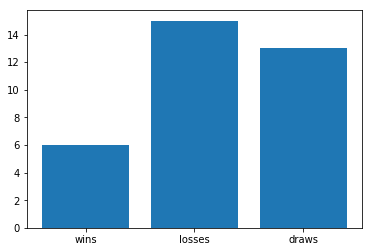

In [371]:
mongo_querier('Aachen')

** IGNORE CELLS BELOW THIS POINT!! **

And now to create a series of graphs with wins vs games played. Following Mike's lead, I will do wins/draws/losses

In [217]:
team_info.loc['Aachen']

draws             13.000000
goals             30.000000
losses            15.000000
rain win ratio     0.230769
win ratio          0.176471
wins               6.000000
Name: Aachen, dtype: float64

<BarContainer object of 3 artists>

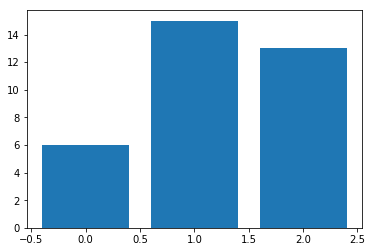

In [222]:
plt.bar([0,1,2], team_info.loc['Aachen',['wins', 'losses', 'draws']])

In [223]:
for team in list_of_teams:
    plt.bar([0,1,2], team_info.loc[team,['wins', 'losses', 'draws']], 
                    tick_label=['wins', 'losses', 'draws'])
    plt.title(team + " 2011 season totals")
    img_folder = "charts/"
    img_format = 'png'
    fname = img_folder + team + '.' + img_format
    plt.savefig(fname, format=img_format)
    plt.clf() # clear the figure

<Figure size 432x288 with 0 Axes>

In [229]:
from pymongo import MongoClient
import gridfs

In [225]:
myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
mydb = myclient['teams_db']
mycollection = mydb['teams']

In [242]:
plot_tuples[0].

<BarContainer object of 3 artists>

In [248]:
for team in list_of_teams:
    data = {'team':team, 'goals':num_goals(team),'wins':num_wins(team),'losses':num_loss(team),
                           'draws':num_draw(team),
                 'win ratio':num_wins(team)/num_games(team),'rain win ratio':rain_wins(team)}
    results = mycollection.insert_one(data)

In [367]:
mycollection.delete_many({})

In [334]:
query_1 = mycollection.find({})
for x in query_1:
    print(x)

{'_id': ObjectId('5ce41c72c1b825180218e749'), 'team': 'Aachen', 'goals': 30, 'wins': 6, 'losses': 15, 'draws': 13, 'win ratio': 0.17647058823529413, 'rain win ratio': 0.23076923076923078}


In [263]:
query_1 = mycollection.find({'team':'Aachen'})
for x in query_1:
    print(x['team'])

Aachen


,Aachen
goals,30.000000
wins,6.000000
draws,13.000000
losses,15.000000
win ratio,0.176471
rain win ratio,0.230769


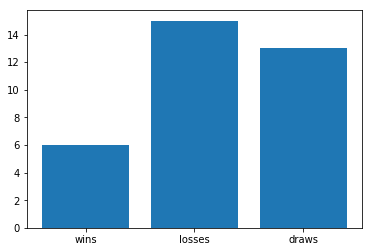

In [308]:
mongo_querier('Aachen')

In [332]:
Aachen = team('Aachen')
Aachen.get_info()

In [333]:
Aachen.upload()

In [178]:
conn = sqlite3.connect('database.sqlite')
c = conn.cursor()
df = pd.DataFrame(c.execute('''select Date, HomeTeam, AwayTeam, FTR from matches 
    where season is 2011 and
    (HomeTeam is '{}' or AwayTeam is '{}')

    '''.format('Hannover','Hannover')
                               ).fetchall())
#    and (HomeTeam is '{}' or AwayTeam is '{}') 
df.columns = [x[0] for x in c.description]
df['precip'] = [weather_df.loc[x]['precip_type'] for x in df['Date']]
df

,Date,HomeTeam,AwayTeam,FTR,precip
0,2011-10-23,Hannover,Bayern Munich,H,rain
1,2011-09-18,Hannover,Dortmund,H,rain
2,2012-03-18,Hannover,FC Koln,H,NA
3,2012-04-22,Hannover,Freiburg,D,NA
4,2011-11-26,Hannover,Hamburg,D,rain
5,2012-05-05,Hannover,Kaiserslautern,H,rain
6,2011-12-10,Hannover,Leverkusen,D,rain
7,2012-01-27,Hannover,Nurnberg,H,NA
8,2011-11-06,Hannover,Schalke 04,D,rain
9,2012-02-19,Hannover,Stuttgart,H,rain


In [41]:
conn = sqlite3.connect('database.sqlite')
c = conn.cursor()
c.execute("""select count(FTR) from matches 
    where season is 2011 
    and (HomeTeam is "{}" or AwayTeam is "{}")
    and FTR is 'D' """.format(team_name)).fetchall()


'Bayern Munich'

In [88]:
resp = requests.get('''https://api.darksky.net/forecast/1281fd7df229b9bd1c337bf4a3b75616/42.3601,-71.0589,
2000-06-01T12:00:00?exclude=[currently,minutely,hourly]''')

In [102]:
start = datetime.datetime(2011,6,1)
result = start+datetime.timedelta(50)

year = str(result.year)
month = str(result.month) if len(str(result.month))==2 else '0'+str(result.month)
day = str(result.day) if len(str(result.day)) == 2 else '0'+str(result.day)

datetime.datetime(2011, 2, 20, 0, 0)

In [94]:
resp = requests.get(url_maker('2012-02-18'))
resp.json()

{'code': 400, 'error': 'The given location (or time) is invalid.'}